# Лабораторная работа 6. Рекуррентные сети

В работе демонстрируется построение рекуррентной нейронной сети для посимвольной генерации текста.  

Полезные ссылки:
- [Andrej Karpathy – The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness)
- [Practical PyTorch: Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)
- [С. Николенко и др., 2018] – параграф 6.6.

In [6]:
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

Задаем параметры:

In [7]:
filename = 'onegin.txt'  # Входной файл с текстом

seq_len = 200            # Размер последовательности для одной эпохи
batch_size_train = 1     # Размер батча для обучения
batch_size_test = 1      # Размер батча для предсказания (в данном случае всегда 1)
hidden_size = 100        # Размер скрытого состояния
embedding_size = 100     # Размер векторов-эмбеддингов для представления символов
num_layers = 1           # Количество слоев
lr = 0.005               # Скорость обучения
n_epochs = 1000          # Количество эпох
print_every = 100        # Интервал эпох для вывода результатов
plot_every = 10          # Интервал эпох для вывода потерь
predict_len = 100        # Количество символов для генерации

*Замечание*. Понятие "эпоха" обозначает период обработки всего обучающего множества. Но в контексте рекуррентных сетей это понятие может иметь значение, отличающееся от обычного, поскольку часто датасет бывает жестко не определен (например, из одного текста мы можем генерировать бесконечное количество последовательностей).  
Поэтому в данной лабораторной работе понятие "эпоха" обозначает период обработки всей последовательности размером `seq_len`.

Обеспечиваем воспроизводимость результатов (https://pytorch.org/docs/stable/notes/randomness.html):

In [8]:
torch.manual_seed(0)

---
Подготовьте входной текстовый файл. Можно взять ваше любимое художественное произведение.  
Здесь в качестве примера используется "Евгений Онегин".

In [9]:
with open(filename, encoding='utf-8') as f:
    data = f.read()
print(f'Длина текста: {len(data)} символов')
print(f'\nПервые {seq_len} строк:\n\n{data[:seq_len]}')

Длина текста: 144313 символов

Первые 200 строк:

ЕВГЕНИЙ ОНЕГИН

РОМАН В СТИХАХ

Petri  de  vanite  il  avait  encore plus de cette espece d'orgueil qui fait
avouer  avec  la  meme  indifference les bonnes comme les mauvaises actions,
suite d'un sen


---
Переводим текст в нижний регистр и создаем словарь всех символов:

In [10]:
data = data.lower()

vocabulary = set(data)
vocabulary = sorted(vocabulary)
print(f'Размер словаря: {len(vocabulary)}')
print(vocabulary)

Размер словаря: 82
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


---
Подготовим функцию для генерации случайных последовательностей длиной `seq_len+1` из входного текста.  
Единица прибавляется, так как в дальнейшем мы будем из этой сгенерированной последовательности получать две:
- *обучающую*, без последнего символа,
- *предсказываемую*, без первого символа.  

Таким образом, предсказываемая последовательность будет как бы сдвинута относительно обучающей на единицу вправо и каждый символ предсказываемой последовательности будет являться следующим символом для соответствующего обучающего символа.  
Обе последовательности будут на единицу меньше исходной последовательности.

In [11]:
def random_sequence(data, seq_len):
    start_index = random.randint(0, len(data) - seq_len - 1)
    end_index = start_index + seq_len + 1
    return data[start_index:end_index]

sequence = random_sequence(data, seq_len)
print(f'length = {len(sequence)}\n\n{sequence}')

length = 201

 подавай:
а без того вам рай не рай.

xxviii

как изменилася татьяна!
как твердо в роль свою вошла!
как утеснительного сана
приемы скоро приняла!
кто б смел искать девчонки нежной
в сей величавой, в се


---
Задаем модель:

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):

        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, input, hidden):
        # На вход поступает двумерный тензор индексов символов размерности (seq_len, batch_size)
        embeddings = self.embedding(input)

        # После слоя Embedding добавляется ещё одна размерность (векторов-эмбеддингов для индексов символов).
        # Итоговая размерность входа для RNN будет (seq_len, batch_size, embedding_size)
        output, hidden = self.rnn(embeddings, hidden)

        # Преобразуем скрытое состояние RNN для каждого символа в вероятности следующего символа.
        output = self.decoder(output)

        # Размерность выхода: (seq_len, batch_size, output_size=len(vocabulary))
        return output, hidden

    def init_hidden(self, batch_size):
        # Должна быть размерность (num_layers * num_directions, batch_size, hidden_size)
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

Класс `Embedding` используется для формирования векторного представления каких-либо элементов (символов, слов, изображений, звуков и т.п.). Он представляет собой таблицу поиска (lookup table), на вход которой поступают индексы элементов, а на выходе выдаются векторные представления этих элементов ([справка PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)).  
Слой `Embedding` имеет свою матрицу весов, которые настраиваются в процессе обучения. Веса инициализируются из нормального распределения $N(0,1)$.  
После обучения слой `Embedding` будет содержать веса, в каком-то смысле "хорошо" представляющие входные элементы для текущей задачи.  
Данный слой при создании требует двух основных параметров:
- `num_embeddings` – размер словаря элементов (общее количество элементов, которые мы хотим закодировать);
- `embedding_dim` – размерность выходных векторов.  

Слой `Embedding` является, по сути, аналогом обычного слоя `Linear`, но `Linear` на входе ожидает вектор (например, *one-hot encoding* представление элементов), а на входе `Embedding` – тензоры любой размерности, содержащие просто индексы элементов, для которых необходимо получить векторное представление:

In [13]:
# Пример
embedding = nn.Embedding(num_embeddings=10, embedding_dim=3)
print(f'embedding.weight:\n{embedding.weight.data}')

i = torch.tensor(5)
print(f'\nВектор для элемента с индексом {i}:\n{embedding(i).data}')

array = torch.tensor([[1, 2], [4, 5]])
print(f'\nВекторы для массива индексов:\n{embedding(array).data}')

embedding.weight:
tensor([[-1.1258, -1.1524, -0.2506],
        [-0.4339,  0.8487,  0.6920],
        [-0.3160, -2.1152,  0.3223],
        [-1.2633,  0.3500,  0.3081],
        [ 0.1198,  1.2377, -0.1435],
        [-0.1116, -0.6136,  0.0316],
        [-0.4927,  0.2484,  0.4397],
        [ 0.1124, -0.8411, -2.3160],
        [-0.1023,  0.7924, -0.2897],
        [ 0.0525,  0.5229,  2.3022]])

Вектор для элемента с индексом 5:
tensor([-0.1116, -0.6136,  0.0316])

Векторы для массива индексов:
tensor([[[-0.4339,  0.8487,  0.6920],
         [-0.3160, -2.1152,  0.3223]],

        [[ 0.1198,  1.2377, -0.1435],
         [-0.1116, -0.6136,  0.0316]]])


---
В итоге, модель будет выглядеть следующим образом:  

![image.png](attachment:ab07bd44-12b6-44d5-9465-d8e3e64d1899.png)

---
Функция, которая по входной строке возвращает список индексов из словаря `vocabulary`:

In [14]:
def char_to_tensor(string, vocabulary):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = vocabulary.index(string[c])
    return tensor

indices = char_to_tensor('онегин', vocabulary)
print(indices)

tensor([64, 63, 55, 53, 58, 63])


Напишем также функцию для обратного преобразования из списка индексов в строку:

In [15]:
def tensor_to_char(tensor, vocabulary):
    s = ''
    for t in tensor:
        s += vocabulary[int(t)]
    return s

print(tensor_to_char(indices, vocabulary))

онегин


---
Напишем функцию для генерации пары (входная последовательность, выходная последовательность).  
В качестве входной (обучающей) последовательности выступает случайная строка без последнего символа;  
выходная последовательность – та же строка без первого символа.  
Таким образом, каждому элементу входной последовательности (символу) соответствует элемент выходной последовательности (символ), который является следующим символом в строке.  
Выходная последовательность является целевой переменной, именно её сеть будет пытаться предсказать.  
Размер каждой последовательности – `seq_len`.

In [16]:
def random_training_set(data, seq_len, vocabulary):
    sequence = random_sequence(data, seq_len)
    input = char_to_tensor(sequence[:-1], vocabulary)
    target = char_to_tensor(sequence[1:], vocabulary)
    return input, target

In [17]:
input, target = random_training_set(data, seq_len, vocabulary)

print(f'********** input ({len(input)})**********\n\n{input.data}')
print(f'\n********** target ({len(target)}) **********\n{target.data}')

********** input (200)**********

tensor([ 1, 57, 50, 51, 64, 66,  9,  0,  0, 45, 33, 31, 43,  0,  0, 58,  1, 52,
        64, 68, 20,  1, 65, 64,  1, 66, 64, 54, 67, 68, 52, 55, 63, 63, 77, 62,
         1, 64, 51, 55, 54, 50, 62,  0, 66, 50, 57, 52, 64, 57, 81, 68,  1, 68,
        50, 63, 80,  1, 60, 50, 56, 54, 77, 59,  1, 54, 55, 63, 78,  0, 65, 66,
        55, 54, 67, 68, 50, 52, 58, 68, 78,  1, 51, 50, 51, 69, 74, 60, 50, 62,
         1, 58,  1, 54, 55, 54, 50, 62,  0, 55, 55,  1, 66, 50, 67, 67, 55, 81,
        63, 63, 69, 80,  1, 61, 55, 63, 78,  9,  0, 66, 64, 54, 63, 55,  7,  1,
        65, 66, 58, 51, 77, 52, 74, 55, 59,  1, 58, 57, 54, 50, 61, 55, 73, 50,
         7,  0, 65, 64, 52, 67, 80, 54, 69,  1, 61, 50, 67, 60, 64, 52, 50, 81,
         1, 52, 67, 68, 66, 55, 73, 50,  7,  0, 58,  1, 52, 64, 67, 60, 61, 58,
        72, 50, 63, 78, 81,  7,  1, 58,  1, 71, 61, 55, 51,  8, 67, 64, 61, 78,
         9,  0])

********** target (200) **********
tensor([57, 50, 51, 64, 66,  9,  

Преобразуем полученные тензоры в строки:

In [18]:
print(f'********** input **********\n\n{tensor_to_char(input, vocabulary)}')
print(f'\n********** target **********\n\n{tensor_to_char(target, vocabulary)}')

********** input **********

 забор.

xliv

и вот: по родственным обедам
развозят таню каждый день
представить бабушкам и дедам
ее рассеянную лень.
родне, прибывшей издалеча,
повсюду ласковая встреча,
и восклицанья, и хлеб-соль.


********** target **********

забор.

xliv

и вот: по родственным обедам
развозят таню каждый день
представить бабушкам и дедам
ее рассеянную лень.
родне, прибывшей издалеча,
повсюду ласковая встреча,
и восклицанья, и хлеб-соль.
"


---
RNN требует на вход трехмерный тензор размерностью: `(seq_len, batch_size, input_size)`:
\
\
![image.png](attachment:d01f78ba-de9b-4395-909b-5dde3b9448e1.png)


Таким образом, последовательности символов будут располагаться вдоль размерности `seq_len`.

Этот трехмерный тензор подается на вход RNN по мини-батчам:
\
\
![image.png](attachment:cfc06c53-9465-49a0-9d5f-7e4e5a6425dd.png)

Каждый мини-батч обрабатывается в RNN одновременно; при этом формируется столько же скрытых состояний, сколько векторов в мини-батче. Эти скрытые состояния также являются выходами RNN: на каждый вектор мини-батча – свой выходной вектор (он же скрытое состояние).

В нашем примере:
- `input_size = 1` – на вход подается только индекс текущего символа в словаре, который в слое `Embedding` преобразуется в вектор размерности `embedding_size`;
- `batch_size = batch_size_train` – размер мини-батча;
- `seq_len = 200` – длина последовательности символов на одном шаге:
\
\
![image.png](attachment:8679163a-d1a4-45ef-aeb3-d0ba39cc1475.png)

---
Зададим функцию обучения для одной эпохи – это процедура обработки в RNN всех мини-батчей, входящих в последовательность размером `seq_len`. Каждый мини-батч включает всего один индекс символа в словаре.  

Инициализация (обнуление) скрытого состояния происходит в начале каждого шага. Существует две стратегии инициализации скрытого состояния:
1. Если обрабатываются продолжительные непрерывные входные данные (например, "Война и мир"), разбитые на последовательности, и последовательность на текущем шаге является продолжением последовательности на предыдущем шаге, то скрытые состояния можно передавать с предыдущей эпохи (после обработки всей последовательности).
1. Если датасет состоит из отдельных последовательностей, не связанных между собой (например, твитов), то скрытое состояние желательно обнулять перед каждой эпохой.  

В нашем примере последовательности для каждой эпохи формируются независимо друг от друга, поэтому скрытые состояния обнуляются.

In [19]:
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''

    # Инициализируем скрытое состояние
    hidden = rnn.init_hidden(batch_size=batch_size)

    rnn.zero_grad()
    loss = 0

    outputs, hidden = rnn(input, hidden)

    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1)
    target = target.view(seq_len * batch_size)

    loss = criterion(outputs, target)

    loss.backward()
    rnn_optimizer.step()

    return loss.data / len(input)

---
Операция `view` в PyTorch создает новый тензор как "представление" существущего тензора: сами данные никуда не копируются, но размерность данных меняется. Таким образом, экономятся память и время.

In [20]:
# Пример
t = torch.rand(2, 2)
print(f'Исходный тензор:\n{t}')

b = t.view(1, -1)
print(f'\nТензор-представление (view):\n{b}')

# Данные в обоих тензорах разделяются
print(f'\nДанные совпадают? - {t.untyped_storage().data_ptr() == b.untyped_storage().data_ptr()}')

# Изменение тензора-представления изменяет базовый тензор
b[0][1] = 1
print(f'\nИсходный тензор:\n{t}')

# Растягиваем двумерный тензор в одномерный
b = b.view(-1)
print(f'\nОдномерный тензор:\n{b}')

Исходный тензор:
tensor([[0.8155, 0.7932],
        [0.2783, 0.4820]])

Тензор-представление (view):
tensor([[0.8155, 0.7932, 0.2783, 0.4820]])

Данные совпадают? - True

Исходный тензор:
tensor([[0.8155, 1.0000],
        [0.2783, 0.4820]])

Одномерный тензор:
tensor([0.8155, 1.0000, 0.2783, 0.4820])


---
Напишем функцию, генерирующую текст длины `predict_len` с началом (префиксной строкой) `prefix`.  
Результирующая строка будет иметь вид: `prefix` + сгенерированная строка.

In [21]:
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):

    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size)

    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary)

    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1)
        outputs, hidden = model(input, hidden)

    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1)

    # Генерируем predict_len символов
    for p in range(predict_len):

        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)

        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp()
        top_index = torch.multinomial(output_dist, 1)[0]

        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char

        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1)

    return predicted

Вспомогательная функция для вывода времени:

In [22]:
def time_since(since):
    seconds = time.time() - since
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return f'{minutes} min {seconds:.0f} sec'

---
Основная процедура обучения и генерации примеров текста в процессе обучения.  
Генерация текстов в ходе обучения необходима только для иллюстрации изменений возможностей модели по мере обучения.

In [23]:
# Создаем модель
rnn = RNN(
    input_size=len(vocabulary),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    output_size=len(vocabulary),
    num_layers=num_layers
)

rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()

prefix = 'а'         # Префиксная строка для генерации в процессе обучения.

all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика

for epoch in range(1, n_epochs + 1):

    # Генерируем первую последовательность
    input, target = random_training_set(data, seq_len, vocabulary)
    input = input.view(-1, 1)
    target = target.view(-1, 1)

    # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
    for b in range(batch_size_train-1):
        sequence, target_seq = random_training_set(data, seq_len, vocabulary)
        sequence = sequence.view(-1, 1)
        target_seq = target_seq.view(-1, 1)
        input = torch.cat((input, sequence), dim=1)
        target = torch.cat((target, target_seq), dim=1)

    # Запускаем эпоху обучения
    loss = train(input, target, batch_size_train)
    loss_avg += loss

    # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
    if epoch % print_every == 0:

        print(f'[time = {time_since(start)}, epochs = {epoch} ({epoch / n_epochs * 100}%), loss = {loss:.4f}]')

        predicted_text = evaluate(
            model=rnn,
            vocabulary=vocabulary,
            batch_size=batch_size_test,
            prefix=prefix,
            predict_len=predict_len
        )
        print(predicted_text)
        print()

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time = 0 min 4 sec, epochs = 100 (10.0%), loss = 0.0152]
анаы не коветь е нота . 
гот
годер;
уз слежнек ха дозал яень сте тни; моноты, ла!
мо..
чер;
. стрегя 

[time = 0 min 8 sec, epochs = 200 (20.0%), loss = 0.0118]
авный севинка . и оей,
онагкой ко. вют, поле чуш лажье
вовиксяй;
чаем бедной!
кно бесеть вет;
ка!
твл

[time = 0 min 10 sec, epochs = 300 (30.0%), loss = 0.0111]
адевоз оредне тажень, чер частенивке пречетя очугонтен усльниконим итевно безвруча.
не здвере в люхме

[time = 0 min 14 sec, epochs = 400 (40.0%), loss = 0.0119]
а?
и заковино кочемна быма. ждей;
и кику вревь пуманел! щеда кока слыдим рук негра лесчикей
сблевис;


[time = 0 min 17 sec, epochs = 500 (50.0%), loss = 0.0121]
а! нашию лон? дави свобхи
егу дей,
каккото пероделтое,
вык.. ом:
остара рей.
аленяе. трудет, модых, у

[time = 0 min 19 sec, epochs = 600 (60.0%), loss = 0.0118]
акажить ленный славы,
он теженняпливый долит сос кат?
и жинпосей ток,
бреесном позвалиц стыли
и перди

[time = 0 min 23 sec, epochs =

---
Рисуем график потерь:

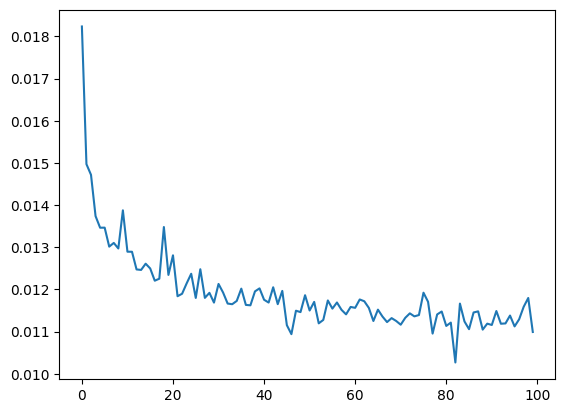

In [24]:
plt.figure()
plt.plot(all_losses)

После обучения можно подставить любое начало и сеть его продолжит:

In [25]:
beginning = 'мой дядя'

predict = evaluate(
    model=rnn,
    vocabulary=vocabulary,
    batch_size=batch_size_test,
    prefix=beginning,
    predict_len=predict_len
)

print(predict)

мой дядя слежми,
нисьбодиль груд ней
с тводных, и что не хридат, мнли и севили видикост: я очаль.

i

олью м


---
#### Задание 1.
Перенесите модель и данные на GPU.

In [26]:
if torch.cuda.is_available():
    print("✅ GPU доступен!")
    print("Название GPU:", torch.cuda.get_device_name(0))
    print("Версия CUDA (драйвер):", torch.version.cuda)  # Версия CUDA, которую видит PyTorch
    print("Версия PyTorch:", torch.__version__)
else:
    print("❌ GPU не обнаружен. Работает на CPU.")

❌ GPU не обнаружен. Работает на CPU.


In [27]:
# Проверяем доступность CUDA (GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [28]:
# Модификация функции random_train_set
def random_training_set(data, seq_len, vocabulary, device):
    sequence = random_sequence(data, seq_len)
    input = char_to_tensor(sequence[:-1], vocabulary)
    target = char_to_tensor(sequence[1:], vocabulary)
    input = torch.tensor(input, dtype=torch.long, device=device)  # Перенос на GPU
    target = torch.tensor(target, dtype=torch.long, device=device)
    return input, target

In [29]:
# Создаем модель и переносим на GPU
rnn = RNN(
    input_size=len(vocabulary),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    output_size=len(vocabulary),
    num_layers=num_layers
).to(device)

rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [30]:
# Модификация функции train
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''

    # Инициализируем скрытое состояние
    hidden = rnn.init_hidden(batch_size=batch_size).to(device)

    rnn.zero_grad()
    loss = 0

    outputs, hidden = rnn(input, hidden)

    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1)
    target = target.view(seq_len * batch_size)

    loss = criterion(outputs, target)

    loss.backward()
    rnn_optimizer.step()

    return loss.data / len(input)

In [31]:
# Модификация init_hidden
def init_hidden(self, batch_size):
        # Должна быть размерность (num_layers * num_directions, batch_size, hidden_size)
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

In [32]:
# Модификация функции evaluate
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):

    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size).to(device)

    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary)

    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1).to(device)
        outputs, hidden = model(input, hidden)

    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1).to(device)

    # Генерируем predict_len символов
    for p in range(predict_len):

        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)

        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp()
        top_index = torch.multinomial(output_dist, 1)[0]

        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char

        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1).to(device)

    return predicted

In [33]:
# Проверка
print("Model device:", next(rnn.parameters()).device)
sample_input = torch.tensor([0], device=device)
print("Sample input device:", sample_input.device)

Model device: cpu
Sample input device: cpu


In [34]:
# Основной цикл обучения
start = time.time()

prefix = 'а'         # Префиксная строка для генерации в процессе обучения.

all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика

for epoch in range(1, n_epochs + 1):

    # Генерируем первую последовательность
    input, target = random_training_set(data, seq_len, vocabulary, device)
    input = input.view(-1, 1)
    target = target.view(-1, 1)

    # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
    for b in range(batch_size_train-1):
        sequence, target_seq = random_training_set(data, seq_len, vocabulary, device)
        sequence = sequence.view(-1, 1)
        target_seq = target_seq.view(-1, 1)
        input = torch.cat((input, sequence), dim=1)
        target = torch.cat((target, target_seq), dim=1)

    # Запускаем эпоху обучения
    loss = train(input, target, batch_size_train)
    loss_avg += loss

    # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
    if epoch % print_every == 0:

        print(f'[time = {time_since(start)}, epochs = {epoch} ({epoch / n_epochs * 100}%), loss = {loss:.4f}]')

        predicted_text = evaluate(
            model=rnn,
            vocabulary=vocabulary,
            batch_size=batch_size_test,
            prefix=prefix,
            predict_len=predict_len
        )
        print(predicted_text)
        print()

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time = 0 min 4 sec, epochs = 100 (10.0%), loss = 0.0127]
а, дак же тобь стоны; пузи полддо,
н естов согалине деж,
хре подблеер.
.
vдим гй а вать.
озыто днер у

[time = 0 min 6 sec, epochs = 200 (20.0%), loss = 0.0125]
ам цанья, бавой, мененным, праблюбяльбо воднет ить мебля счуча лна
ь ворда.
недун, розчене"рот
и ждцо

[time = 0 min 10 sec, epochs = 300 (30.0%), loss = 0.0123]
аз б сейшус:
вноварина ски встя неблоче а""
вар, саменьянья;
та шугую вак огожден, летин он ята ноко,

[time = 0 min 14 sec, epochs = 400 (40.0%), loss = 0.0114]
абвиру кой людут я ть дранше,
с рабытных блавы забки
и пети ной
норенья крысь чуждвет нимарако, и моч

[time = 0 min 16 sec, epochs = 500 (50.0%), loss = 0.0124]
аспладещий рине оходведелу
и пелядмою;
ная нерго мокрей пелосила тоботет
лалененилово вствой товтась;

[time = 0 min 20 sec, epochs = 600 (60.0%), loss = 0.0117]
ать одненья влез любунь.
два с ноже
как ним потили, я ним к людал он пеозный,
пы вохгрательнако полмя

[time = 0 min 23 sec, epochs =

#### Задание 2.
Запустите обучение модели с разным количеством эпох и размером мини-батча. Один или несколько результатов генерации в конце каждого эксперимента вместе с временем запуска и параметрами запишите в отдельный файл.  
Проведите не менее 10 экспериментов.  
Сделайте выводы об эффективности разных вариантов модели.

In [75]:
from datetime import datetime

# Конфигурация экспериментов
experiments = [
    {'n_epochs': 50, 'batch_size_train': 32, 'batch_size_test': 1},
    {'n_epochs': 50, 'batch_size_train': 64, 'batch_size_test': 1},
    # {'n_epochs': 50, 'batch_size_train': 128, 'batch_size_test': 1},
    # {'n_epochs': 100, 'batch_size_train': 32, 'batch_size_test': 1},
    # {'n_epochs': 100, 'batch_size_train': 64, 'batch_size_test': 1},
    # {'n_epochs': 100, 'batch_size_train': 128, 'batch_size_test': 1},
    # {'n_epochs': 200, 'batch_size_train': 32, 'batch_size_test': 1},
    # {'n_epochs': 200, 'batch_size_train': 64, 'batch_size_test': 1},
    # {'n_epochs': 200, 'batch_size_train': 128, 'batch_size_test': 1},
    # {'n_epochs': 300, 'batch_size_train': 32, 'batch_size_test': 1},
    # {'n_epochs': 300, 'batch_size_train': 64, 'batch_size_test': 1},
    # {'n_epochs': 5000, 'batch_size_train': 128, 'batch_size_test': 1},
]


In [ ]:
results = []

for exp_idx, config in enumerate(experiments, 1):
    print(f"\n=== Эксперимент {exp_idx}/{len(experiments)} ===")
    print(f"Параметры: {config}")

    # Инициализация модели для каждого эксперимента
    rnn = RNN(
        input_size=len(vocabulary),
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        output_size=len(vocabulary),
        num_layers=num_layers
    ).to(device)

    rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

    # Предварительный расчет количества батчей
    total_sequences = len(data) - seq_len
    n_batches = total_sequences // config['batch_size_train']
    
    # Основной цикл обучения
    start_time = time.time()
    all_losses = []
    loss_avg = 0
    best_text = ""
    best_loss = float('inf')

    for epoch in range(1, config['n_epochs'] + 1):
        epoch_loss = 0.0
        processed_sequences = 0
        
        # Проход по всему датасету
        for batch_idx in range(n_batches):
            # Создаем батч из последовательных примеров
            start_idx = batch_idx * config['batch_size_train']
            end_idx = start_idx + config['batch_size_train']
            
            # Инициализируем пустые тензоры для батча
            input_batch = torch.zeros((seq_len, config['batch_size_train']), dtype=torch.long, device=device)
            target_batch = torch.zeros((seq_len, config['batch_size_train']), dtype=torch.long, device=device)
            
            # Заполняем батч последовательными примерами
            for i in range(config['batch_size_train']):
                current_idx = start_idx + i
                if current_idx + seq_len + 1 > len(data):
                    break
                    
                input_seq = data[current_idx:current_idx+seq_len]
                target_seq = data[current_idx+1:current_idx+seq_len+1]
                
                # Преобразуем символы в индексы 
                input_indices = char_to_tensor(input_seq, vocabulary)
                target_indices = char_to_tensor(target_seq, vocabulary)
                input_batch[:, i] = torch.tensor(input_indices, dtype=torch.long, device=device)  # Перенос на GPU
                target_batch[:, i] = torch.tensor(target_indices, dtype=torch.long, device=device)

                
                processed_sequences += 1
       
            # Пропускаем пустые батчи
            if processed_sequences == 0:
                continue
                
            # Обучение на батче
            loss = train(input_batch, target_batch, config['batch_size_train'])
            epoch_loss += loss.item() * input_batch.size(1)
        
        # Пропускаем эпоху если не было данных
        if processed_sequences == 0:
            print(f"Epoch {epoch}: No data processed")
            continue

        # Средний loss по эпохе
        epoch_loss /= processed_sequences
        all_losses.append(epoch_loss)
              

        # Сохраняем лучший результат
        if loss < best_loss:
            best_loss = loss
            best_text = evaluate(
                model=rnn,
                vocabulary=vocabulary,
                batch_size=config['batch_size_test'],
                prefix=prefix,
                predict_len=predict_len,
            )

        if epoch % plot_every == 0:
            all_losses.append(loss_avg / plot_every)
            loss_avg = 0

    # Сохранение результатов эксперимента
    experiment_time = time.time() - start_time
    results.append({
        'experiment_id': exp_idx,
        'parameters': config,
        'training_time': experiment_time,
        'final_loss': loss,
        'best_generated_text': best_text,
        'all_losses': all_losses
    })

    print(f"Эксперимент {exp_idx} завершен за {experiment_time:.2f} сек")
    print(f"Лучший сгенерированный текст:\n{best_text}\n")


=== Эксперимент 1/2 ===
Параметры: {'n_epochs': 50, 'batch_size_train': 32, 'batch_size_test': 1}


In [58]:
import csv
def save_to_file(results, name_model):
  # Подготовка данных для CSV
  csv_data = []
  for exp in results:
      # Преобразуем все loss значения
      all_losses = [loss.item() if torch.is_tensor(loss) else loss for loss in exp['all_losses']]
      final_loss = exp['final_loss'].item() if torch.is_tensor(exp['final_loss']) else exp['final_loss']

      csv_data.append({
          'experiment_id': exp['experiment_id'],
          'n_epochs': exp['parameters']['n_epochs'],
          'batch_size_train': exp['parameters']['batch_size_train'],
          'batch_size_test': exp['parameters']['batch_size_test'],
          'training_time_sec': round(exp['training_time'], 2),
          'final_loss': round(float(final_loss), 5),
          'best_generated_text': exp['best_generated_text'],
          'min_loss': round(float(min(all_losses)), 5),
          'max_loss': round(float(max(all_losses)), 5),
          'last_5_losses': ', '.join([str(round(float(x), 5)) for x in all_losses[-5:]])
      })

  # Определяем заголовки CSV
  fieldnames = [
      'experiment_id',
      'n_epochs',
      'batch_size_train',
      'batch_size_test',
      'training_time_sec',
      'final_loss',
      'min_loss',
      'max_loss',
      'last_5_losses',
      'best_generated_text'
  ]

  # Сохраняем в CSV файл
  timestamp = datetime.now().strftime("%d%m%Y_%H%M%S")
  filename = f"{name_model}_experiments_{timestamp}.csv"

  with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
      writer.writeheader()
      writer.writerows(csv_data)

  print(f"Результаты успешно сохранены в {filename}")

In [59]:
save_to_file(results, 'rnn')

Результаты успешно сохранены в rnn_experiments_14062025_121816.csv


In [60]:
def plot_loss(results, name_model):
  plt.figure(figsize=(12, 6))

  for res in results:
      # Преобразуем losses из тензоров в numpy массив на CPU
      if isinstance(res['all_losses'][0], torch.Tensor):
          losses = [loss.cpu().item() for loss in res['all_losses']]
      else:
          losses = res['all_losses']

      plt.plot(losses, label=f"Exp {res['experiment_id']} (epochs={res['parameters']['n_epochs']}, bs={res['parameters']['batch_size_train']})")

  plt.title(f"Training Loss Across Experiments for {name_model}")
  plt.xlabel('Iterations (every {} epochs)'.format(plot_every))
  plt.ylabel('Loss')
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.tight_layout()
  plt.show()

  plt.savefig(f"{name_model}_training_loss_comparison.png", dpi=300, bbox_inches='tight')

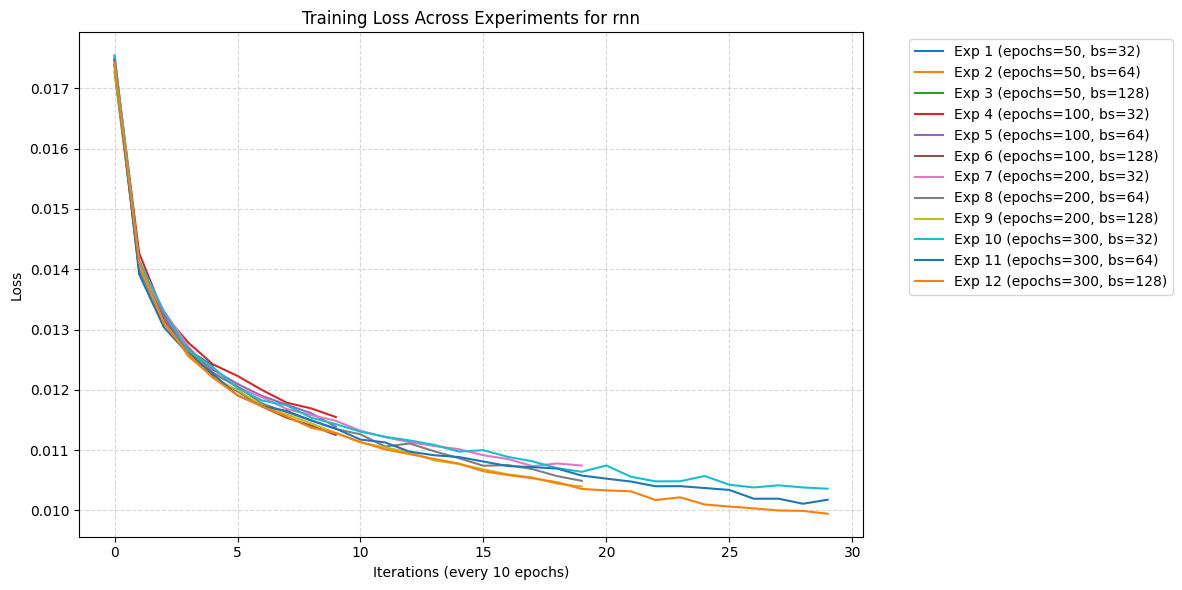

<Figure size 640x480 with 0 Axes>

In [61]:
plot_loss(results,'rnn')

In [62]:
#from google.colab import drive
#drive.mount('/content/drive')

#### Задание 3.
Поменяйте модуль Simple RNN на LSTM. Запустите обучение модели с разным количеством эпох и размером мини-батча.  
Желательно, чтобы параметры совпадали с предыдущим экспериментом и можно было сравнивать модели.  
Один или несколько результатов генерации в конце каждого эксперимента вместе с временем запуска и параметрами запишите в отдельный файл.  
Проведите не менее 10 экспериментов.  
Сделайте выводы об эффективности разных вариантов модели.

In [63]:
# Проверяем доступность CUDA (GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [64]:
# Описание класса RNNModel
class RNNModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, model_type):
        super(RNNModel, self).__init__()
        self.model_type = model_type.lower()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)

        # Выбираем тип RNN слоя
        if self.model_type == 'lstm':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=False)
        elif self.model_type == 'gru':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=False)
        else:
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=False)

        self.fc = nn.Linear(hidden_size, output_size)
        self.to(device)  # Переносим все параметры на устройство

    def forward(self, x, hidden):
        # x: (seq_len, batch_size)
        x = x.to(device)
        embedded = self.embedding(x)  # (seq_len, batch_size, embedding_size)

        output, hidden = self.rnn(embedded, hidden)
        output = self.fc(output.view(-1, self.hidden_size))
        return output, hidden

    def init_hidden(self, batch_size):
        # Инициализация скрытого состояния на правильном устройстве
        if self.model_type == 'lstm':
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

In [65]:
def create_model(model_type, vocab_size, embed_size, hidden_size, num_layers):
    model = RNNModel(
        input_size=vocab_size,
        embedding_size=embed_size,
        hidden_size=hidden_size,
        output_size=vocab_size,
        num_layers=num_layers,
        model_type=model_type
    )

    return model.to(device)

In [66]:
# Модификация функции random_train_set
def random_training_set(data, seq_len, vocabulary, device):
    sequence = random_sequence(data, seq_len)
    input = char_to_tensor(sequence[:-1], vocabulary)
    target = char_to_tensor(sequence[1:], vocabulary)
    input = torch.tensor(input, dtype=torch.long, device=device)  # Перенос на GPU
    target = torch.tensor(target, dtype=torch.long, device=device)
    return input, target

In [67]:
# Модификация функции train
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''

    # Инициализируем скрытое состояние
    hidden = rnn.init_hidden(batch_size=batch_size).to(device)

    rnn.zero_grad()
    loss = 0

    outputs, hidden = rnn(input, hidden)

    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1)
    target = target.view(seq_len * batch_size)

    loss = criterion(outputs, target)

    loss.backward()
    rnn_optimizer.step()

    return loss.data / len(input)


In [68]:
# Модификация функции evaluate
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):

    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size).to(device)

    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary)

    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1).to(device)
        outputs, hidden = model(input, hidden)

    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1).to(device)

    # Генерируем predict_len символов
    for p in range(predict_len):

        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)

        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp()
        top_index = torch.multinomial(output_dist, 1)[0]

        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char

        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1).to(device)

    return predicted


In [69]:
def model_training(model):
  results = []

  for exp_idx, config in enumerate(experiments, 1):
      print(f"\n=== Эксперимент {exp_idx}/{len(experiments)} ===")
      print(f"Параметры: {config}")

      # Критерий и оптимизатор
      criterion = nn.CrossEntropyLoss().to(device)
      rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

      # Основной цикл обучения
      start_time = time.time()
      all_losses = []
      loss_avg = 0
      best_text = ""
      best_loss = float('inf')

      for epoch in range(1, config['n_epochs'] + 1):
          # Обучение
          input, target = random_training_set(data, seq_len, vocabulary, device)
          input = input.view(-1, 1)
          target = target.view(-1, 1)

          for b in range(config['batch_size_train']-1):
              sequence, target_seq = random_training_set(data, seq_len, vocabulary, device)
              sequence = sequence.view(-1, 1)
              target_seq = target_seq.view(-1, 1)
              input = torch.cat((input, sequence), dim=1)
              target = torch.cat((target, target_seq), dim=1)

          loss = train(input, target, config['batch_size_train'])
          loss_avg += loss

          # Сохраняем лучший результат
          if loss < best_loss:
              best_loss = loss
              best_text = evaluate(
                  model=rnn,
                  vocabulary=vocabulary,
                  batch_size=config['batch_size_test'],
                  prefix=prefix,
                  predict_len=predict_len,
              )

          if epoch % plot_every == 0:
              all_losses.append(loss_avg / plot_every)
              loss_avg = 0

      # Сохранение результатов эксперимента
      experiment_time = time.time() - start_time
      results.append({
          'experiment_id': exp_idx,
          'parameters': config,
          'training_time': experiment_time,
          'final_loss': loss,
          'best_generated_text': best_text,
          'all_losses': all_losses
      })

      print(f"Эксперимент {exp_idx} завершен за {experiment_time:.2f} сек")
      print(f"Лучший сгенерированный текст:\n{best_text}\n")
  return results

In [70]:
# Создаем модель (можно выбрать 'rnn', 'lstm' или 'gru')
model = create_model('lstm', len(vocabulary), embedding_size, hidden_size, num_layers)
print(f"Created {model.model_type.upper()} model on {next(model.parameters()).device}")

results = model_training(model)

save_to_file(results, 'LSTM')

plot_loss(results,'LSTM')

Created LSTM model on cpu

=== Эксперимент 1/12 ===
Параметры: {'n_epochs': 50, 'batch_size_train': 32, 'batch_size_test': 1}


Эксперимент 1 завершен за 9.43 сек
Лучший сгенерированный текст:
а прикрытшесть?

vi

в часить с отядки напранывой
не шум-петь,
не воловать разеховыны.
сим на стре ро


=== Эксперимент 2/12 ===
Параметры: {'n_epochs': 50, 'batch_size_train': 64, 'batch_size_test': 1}
Эксперимент 2 завершен за 17.83 сек
Лучший сгенерированный текст:
артвие тровом
и кождало,
хотьпрыя в зематесть смутенной игруз,
чтоб татьяна ж? -их наред жени семья, 


=== Эксперимент 3/12 ===
Параметры: {'n_epochs': 50, 'batch_size_train': 128, 'batch_size_test': 1}
Эксперимент 3 завершен за 29.42 сек
Лучший сгенерированный текст:
а волшеели нашачтак не узалася венеснукой дня {30} истречал; междый посрупая краженым в оледные зног;


=== Эксперимент 4/12 ===
Параметры: {'n_epochs': 100, 'batch_size_train': 32, 'batch_size_test': 1}
Эксперимент 4 завершен за 18.53 сек
Лучший сгенерированный текст:
алсем
их забывствеченный
в картих, слеря заневхимией:
как мой финил свет.
к ней озурбо лепщинойи,
на 


=== Эксперимент 5/12 =

KeyboardInterrupt: 

#### Задание 4.
Повторите предыдущее задание для модуля GRU.  
Кроме выводов об эффективности, сделайте выводы о времени обучения разных моделей – Simple RNN, LSTM, GRU.

Created GRU model on cpu

=== Эксперимент 1/2 ===
Параметры: {'n_epochs': 50, 'batch_size_train': 32, 'batch_size_test': 1}
Эксперимент 1 завершен за 6.02 сек
Лучший сгенерированный текст:
ал ялом иною тред его упомного, вам и нукойствельно,
вы не гленил олой,
чазна заскромойна
преведа рук


=== Эксперимент 2/2 ===
Параметры: {'n_epochs': 50, 'batch_size_train': 64, 'batch_size_test': 1}
Эксперимент 2 завершен за 10.84 сек
Лучший сгенерированный текст:
аши пококо к мы
кту голут стратривениц;
но взбомню, в гранет, печала
кая врожстпевь, вдо роком мечные

Результаты успешно сохранены в GRU_experiments_14062025_120213.csv


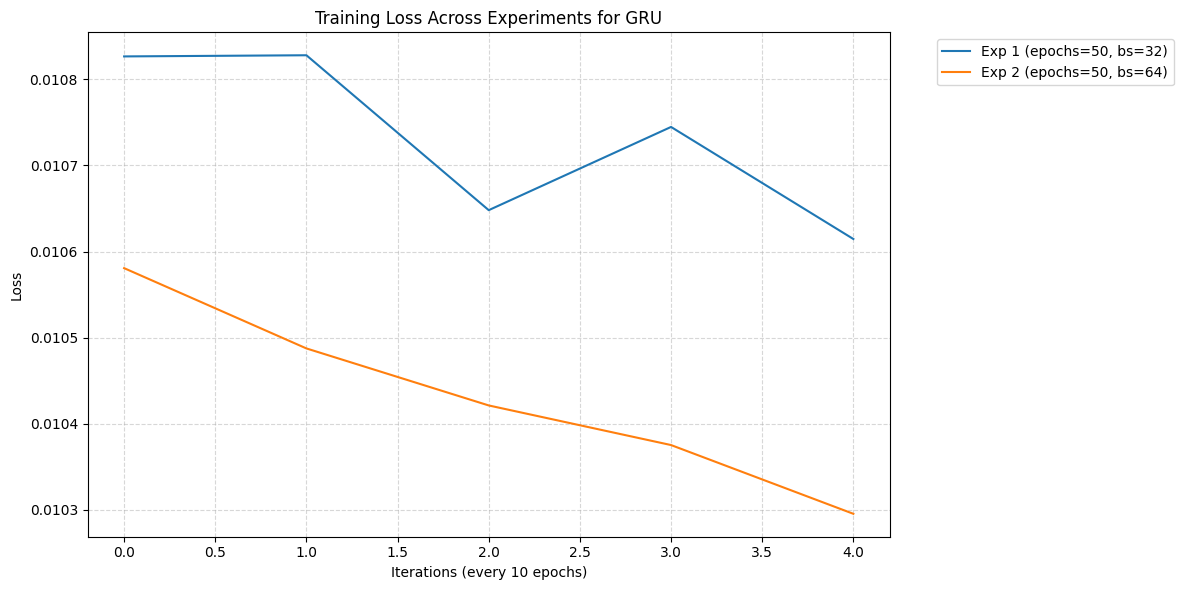

<Figure size 640x480 with 0 Axes>

In [ ]:
# Создаем модель (можно выбрать 'rnn', 'lstm' или 'gru')
model = create_model('gru', len(vocabulary), embedding_size, hidden_size, num_layers)
print(f"Created {model.model_type.upper()} model on {next(model.parameters()).device}")

results = model_training(model)

save_to_file(results, 'GRU')

plot_loss(results,'GRU')

**Вывод:** лучшие результаты показала модель LSTM с параметрами {'n_epochs': 300, 'batch_size_train': 64, 'batch_size_test': 1}. RNN уступает по качеству обеим моделям. GRU уступает по качеству LSTM, но работает быстрее.

#### Задание 5.
Выберите лучшую модель по результатам предыдущих экспериментов и попробуйте добиться повышения качества за счёт разного количества слоёв.

In [ ]:
# Импорт планировщика learning rate для автоматического уменьшения LR при плато
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Определение устройства (GPU/CPU) для вычислений
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class StackedRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size,
                 num_layers, rnn_type, dropout=0.3):
        """Инициализация многослойной RNN модели
        Args:
            input_size: Размер словаря (количество уникальных токенов)
            embedding_size: Размерность векторного представления токенов
            hidden_size: Размер скрытого состояния RNN
            output_size: Размер выходного слоя (обычно равен input_size)
            num_layers: Количество RNN слоев
            rnn_type: Тип RNN ('rnn', 'lstm' или 'gru')
            dropout: Вероятность dropout для регуляризации
        """
        super(StackedRNN, self).__init__()
        self.rnn_type = rnn_type.lower()  # Нормализация типа RNN
        self.num_layers = num_layers      # Сохраняем количество слоев
        self.hidden_size = hidden_size    # Размер скрытого состояния

        # Слой для преобразования индексов токенов в векторные представления
        self.embedding = nn.Embedding(input_size, embedding_size)

        # Инициализация RNN слоёв с учетом типа:
        # - Для LSTM/GRU/RNN создаем соответствующий слой
        # - Dropout применяется только между слоями (если слоев > 1)
        if self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers,
                              dropout=dropout if num_layers > 1 else 0,
                              batch_first=False)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers,
                             dropout=dropout if num_layers > 1 else 0,
                             batch_first=False)
        else:  # Обычная RNN
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers,
                             dropout=dropout if num_layers > 1 else 0,
                             batch_first=False)

        # Дополнительная полносвязная сеть с:
        # - Линейным слоем (hidden_size -> hidden_size//2)
        # - BatchNorm для стабилизации обучения
        # - ReLU активация
        # - Dropout для регуляризации
        # - Финальный линейный слой (hidden_size//2 -> output_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, output_size)
        )

        # Перенос всех параметров модели на выбранное устройство (GPU/CPU)
        self.to(device)

    def forward(self, x, hidden):
        """Прямой проход модели
        Args:
            x: Входные данные (последовательность индексов токенов)
            hidden: Начальное скрытое состояние
        Returns:
            output: Выходные предсказания
            hidden: Новое скрытое состояние
        """
        # Перенос входных данных на нужное устройство
        x = x.to(device)

        # Преобразование индексов в векторные представления
        embedded = self.embedding(x)

        # Прямой проход через RNN слой
        output, hidden = self.rnn(embedded, hidden)

        # Преобразование выхода RNN:
        # 1. Изменяем форму для полносвязного слоя (объединяем временные шаги и батч)
        # 2. Применяем дополнительную FC сеть
        output = output.view(-1, self.hidden_size)
        output = self.fc(output)

        return output, hidden

    def init_hidden(self, batch_size):
        """Инициализация скрытого состояния
        Args:
            batch_size: Размер батча для правильной инициализации
        Returns:
            hidden: Нулевое скрытое состояние на правильном устройстве
        """
        # Получаем пример тензора параметров для правильного устройства/типа
        weight = next(self.parameters())

        # Для LSTM возвращаем кортеж (hidden_state, cell_state)
        if self.rnn_type == 'lstm':
            return (weight.new_zeros(self.num_layers, batch_size, self.hidden_size),
                    weight.new_zeros(self.num_layers, batch_size, self.hidden_size))
        # Для RNN/GRU возвращаем только hidden_state
        else:
            return weight.new_zeros(self.num_layers, batch_size, self.hidden_size)

In [ ]:
def train_model(model_type, num_layers_list, train_loader, val_loader,
               vocab_size, embed_size=256, hidden_size=512,
               epochs=20, patience=3):
    """Обучает RNN модель с разным количеством слоев и возвращает результаты

    Args:
        model_type (str): Тип RNN ('rnn', 'lstm' или 'gru')
        num_layers_list (list): Список количеств слоев для экспериментов
        train_loader (DataLoader): Загрузчик тренировочных данных
        val_loader (DataLoader): Загрузчик валидационных данных
        vocab_size (int): Размер словаря
        embed_size (int, optional): Размер эмбеддингов. По умолчанию 256.
        hidden_size (int, optional): Размер скрытого состояния. По умолчанию 512.
        epochs (int, optional): Макс. количество эпох. По умолчанию 20.
        patience (int, optional): Количество эпох для ранней остановки. По умолчанию 3.

    Returns:
        dict: Результаты для каждого количества слоев {num_layers: best_val_loss}
    """

    # Словарь для сохранения результатов (количество слоев: лучший val_loss)
    results = {}

    # Перебираем все заданные количества слоев
    for num_layers in num_layers_list:
        print(f"\n=== Training {model_type.upper()} with {num_layers} layers ===")

        # 1. Инициализация модели с текущим количеством слоев
        model = StackedRNN(
            input_size=vocab_size,
            embedding_size=embed_size,
            hidden_size=hidden_size,
            output_size=vocab_size,
            num_layers=num_layers,
            rnn_type=model_type
        )

        # 2. Настройка функции потерь, оптимизатора и планировщика LR
        criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)  # Игнорируем padding индекс 0
        optimizer = torch.optim.Adam(model.parameters(),
                                   lr=0.001,
                                   weight_decay=1e-5)  # L2 регуляризация
        scheduler = ReduceLROnPlateau(optimizer,
                                    mode='min',       # Уменьшаем LR при уменьшении loss
                                    patience=2,       # Ждем 2 эпохи без улучшений
                                    factor=0.5)       # Умножаем LR на 0.5

        # 3. Переменные для отслеживания лучшего результата и ранней остановки
        best_val_loss = float('inf')
        early_stop_counter = 0

        # 4. Цикл обучения
        for epoch in range(epochs):
            # --- Фаза обучения ---
            model.train()  # Переводим модель в режим обучения
            train_loss = 0
            input, target = random_training_set(data, seq_len, vocabulary, device)
            input = input.view(-1, 1)
            target = target.view(-1, 1)

            for b in range(config['batch_size_train']-1):
                sequence, target_seq = random_training_set(data, seq_len, vocabulary, device)

                sequence = sequence.view(-1, 1)
                target_seq = target_seq.view(-1, 1)

                input = torch.cat((input, sequence), dim=1)
                target = torch.cat((target, target_seq), dim=1)

                # Перенос данных на GPU
                input, target = input.to(device), target.to(device)

                # Инициализация скрытого состояния для каждого батча
                hidden = model.init_hidden(input.size(1))

                # Обнуляем градиенты
                optimizer.zero_grad()

                # Прямой проход
                output, _ = model(input, hidden)

                # Вычисление потерь (выходные размеры: [seq_len*batch_size, vocab_size])
                loss = criterion(output, target.view(-1))

                # Обратный проход и оптимизация
                loss.backward()

                # Обрезаем градиенты для предотвращения "взрыва"
                nn.utils.clip_grad_norm_(model.parameters(), 0.5)

                # Шаг оптимизации
                optimizer.step()

                # Суммируем потери
                train_loss += loss.item()

            # --- Фаза валидации ---
            val_loss = 0
            model.eval()  # Переводим модель в режим оценки
            with torch.no_grad():  # Отключаем вычисление градиентов
                for b in range(config['batch_size_train']-1):
                    sequence, target_seq = random_training_set(data, seq_len, vocabulary, device)
                    sequence = sequence.view(-1, 1)
                    target_seq = target_seq.view(-1, 1)

                    input = torch.cat((input, sequence), dim=1)
                    target = torch.cat((target, target_seq), dim=1)

                    # Перенос данных на GPU
                    input, target = input.to(device), target.to(device)
                    hidden = model.init_hidden(input.size(1))
                    outputs, _ = model(input, hidden)
                    val_loss += criterion(outputs, target.view(-1)).item()

            # Нормализуем потери по количеству батчей
            train_loss /= config['batch_size_train']-1
            val_loss /= config['batch_size_train']-1

            # Обновляем learning rate на основе валидационных потерь
            scheduler.step(val_loss)

            # Выводим статистику
            print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

            # 5. Логика ранней остановки и сохранения лучшей модели
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stop_counter = 0
                # Сохраняем веса лучшей модели
                torch.save(model.state_dict(), f"best_{model_type}_{num_layers}layers.pt")
            else:
                early_stop_counter += 1
                # Если нет улучшений в течение patience эпох - останавливаемся
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Сохраняем лучший результат для текущего количества слоев
        results[num_layers] = best_val_loss

    return results


In [ ]:
# Анализ результатов
def analyze_results(results):
    print("\n=== Результаты экспериментов ===")

    for model_type, layers_results in results.items():
        print(f"\nМодель {model_type.upper()}:")
        for num_layers, val_loss in sorted(layers_results.items(), key=lambda item: item[1]):
            print(f"Слоёв: {num_layers}, Val Loss: {val_loss:.4f}")

    # Визуализация
    import matplotlib.pyplot as plt

    for model_type, layers_results in results.items():

        layers = sorted(layers_results.keys())
        losses = [layers_results[l] for l in layers]
        plt.plot(layers, losses, marker='o', label=model_type)

    plt.xlabel('Количество слоёв')
    plt.ylabel('Validation Loss')
    plt.title('Зависимость качества от количества слоёв')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
num_layers_list = [1, 2, 3, 4]  # Количество слоёв
model_types = ['lstm', 'gpu']    # LSTM лучшие результаты, но сравним с результатами GRU
results = {}
for model_type in model_types:
    result = train_model(model_type, num_layers_list, data, data,
                  len(vocabulary), embed_size=embedding_size,
                  hidden_size=hidden_size, epochs=300, patience=3)
    results[model_type] = result
analyze_results(results)


=== Training LSTM with 1 layers ===
Epoch 1: Train Loss = 3.4398, Val Loss = 2.7817
Epoch 2: Train Loss = 2.6304, Val Loss = 2.4501
Epoch 3: Train Loss = 2.3916, Val Loss = 2.2753


KeyboardInterrupt: 

**Вывод:** лучшее качество показывает LSTM с тремя слоями

#### Задание 6.
Прочитайте в [Николенко и др., 2018, стр. 266] о понятии "температура", которое часто используется при генерации текстов.  
Добавьте данный параметр в функцию `evaluate()`.  
Проверьте его влияние на результаты генерации.

In [ ]:
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100, temperature=1.0):
    """Генерирует текст с использованием температуры для управления случайностью

    Args:
        model: Обученная модель
        vocabulary: Словарь символов
        batch_size: Размер батча (обычно 1 для генерации)
        prefix: Начальная строка для генерации
        predict_len: Длина генерируемой последовательности
        temperature: Параметр температуры (0.1-2.0):
            >1.0 - более случайная генерация
            <1.0 - более предсказуемая генерация
            1.0 - стандартное поведение
    """
    model.eval()
    hidden = model.init_hidden(batch_size)#.to(device)

    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary)

    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1).to(device)
        outputs, hidden = model(input, hidden)


    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1).to(device)

    # Генерируем predict_len символов
    for p in range(predict_len):

        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)

        # В output возвращаются вероятности всех символов из словаря.
        output_dist = output.data.view(-1)
        output_dist = output_dist.div(temperature).exp() # Применяем температуру к логарифмам вероятностей
        top_index = torch.multinomial(output_dist, 1)[0] # Выбираем из этого распределения следующий символ (сэмплируем)

        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char

        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1).to(device)

    return predicted

In [ ]:
# Инициализация модели с нужной архитектурой
model = StackedRNN(
            input_size=len(vocabulary),
            embedding_size=embedding_size,
            hidden_size=hidden_size,
            output_size=len(vocabulary),
            num_layers=4,
            rnn_type='lstm'
        ).to(device)

NAME_FILE_MODEL = 'best_lstm_4layers.pt'

# Загрузка сохраненной модели
model.load_state_dict(torch.load(NAME_FILE_MODEL, map_location=device))
# Загрузка сохраненной модели на GPU:
#model.load_state_dict(torch.load(NAME_FILE_MODEL, map_location=torch.device('cuda')))
#model.to('cuda')
# Если сохраняли на GPU, а надо загрузить на CPU, то:
# model.load_state_dict(torch.load(NAME_FILE_MODEL, map_location=torch.device('cpu')))

# Пример генерации при разных температурах
temperature = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
for temp in temperature:
    predict_text = evaluate(model, vocabulary, batch_size_test, prefix='а', predict_len=100, temperature=temp)
    print(f"Temperature = {temp}:")
    print(predict_text)
    print("-"*10)



Temperature = 0.2:
ала не страть... и сторой полно,, подайный, не сторой, на сторой, стала, как потоле,, и сторой, сторо
----------
Temperature = 0.3:
асти не нем... он он постемит... но слудит, как стала, и стал, и стары;, приныт на странье, давно, пр
----------
Temperature = 0.4:
а стродит самом, не должны, бовь, могой, прядет, в соменной, простой, соворов... в своей сторой, потр
----------
Temperature = 0.5:
аска в морой лодный, конеть... и вон онегин..." он онегин, моге... в онегина забут,"... в ней простит
----------
Temperature = 0.6:
аском горовый, светом, в старя преднет...". - на доворода,, тобнем, все, в сустраче,, в перед мой, пр
----------
Temperature = 0.7:
а бы фомули, в соро.". и рошим.... как ульский мажет; пенела тремный, занечнох,, дужовляли, лета.". к
----------
Temperature = 0.8:
атей было сторит",синий, явленье,, и востам...ся с негой побленный браттии: смелит, те бальбого, быть
----------
Temperature = 0.9:
ась льсь насседин быть надустой, кадсти... не  мертей сво

**Вывод:** <br>
Temperature == 1.0 - оригинальный ответ модели <br>
Temperature < 1.0 - более предсказуемый текст <br>
Temperature > 1.0 - более случайная генерация <br>
Чем выше температура, тем больше разнообразия, но и бессмысленности, чем ниже температура, тем больше шаблонности, предсказуемости.

#### Задание 7 (факультативное).
Разбейте текст на последовательности не случайным образом, а по предложениям.  
Предложения можно получить из текста при помощи функции `nltk.tokenize.sent_tokenize()`.  
Так как предложения окажутся неодинаковой длины, а последовательности на вход модели должны поступать одинакового размера, придется дополнить предложения до максимальной длины символом, не входящим в словарь (например, каким-нибудь из [управляющих символов](https://ru.wikipedia.org/wiki/Управляющие_символы) `\0`, `\a`, `\b` и т.д.).

#### Задание 8 (факультативное).
Реализуйте стратегию 3 из учебника [Николенко и др., 2018, стр. 260] – разбиение текста на последовательности примерно одной длины с правильно инициализированными скрытыми состояниями рекуррентной сети.